In [61]:
import numpy as np
import pandas as pd 
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.model_selection import StratifiedKFold
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
training_raw = pd.read_csv('train.csv')
testing_raw = pd.read_csv('test.csv')
combine = [training_raw, testing_raw]

In [5]:
training_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
training_raw.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
training_raw.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Frost, Mr. Anthony Wood ""Archie""",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


In [8]:
#CHecking missing values
training_raw.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
testing_raw.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
#filling missing values with respect to gender and Pclass
age_by_X = np.zeros(shape = [2,3])

age_by_X

array([[0., 0., 0.],
       [0., 0., 0.]])

In [11]:
gender_mapping = {'male':0, 'female':1}
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map(gender_mapping)

In [12]:
training_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [13]:
dataset_for_age = pd.concat([training_raw[['Sex', 'Age', 'Pclass']], testing_raw[['Sex', 'Age', 'Pclass']]])

In [14]:
dataset_for_age.shape

(1309, 3)

In [15]:
#for age imputataion
for sex in range(2):
    for pclass in range(3):
        age_by_X[sex, pclass] = dataset_for_age.loc[(dataset_for_age['Sex'] == sex) & (dataset_for_age['Pclass'] == (pclass + 1)), 'Age' ].mean().round()

In [16]:
age_by_X

array([[41., 31., 26.],
       [37., 27., 22.]])

In [17]:
for dataset in combine:
    for sex in range(2):
        for pclass in range(3):
            dataset.loc[(dataset['Age'].isnull()) & (dataset['Sex'] == sex) & (dataset['Pclass'] == (pclass + 1)), 'Age'] = age_by_X[sex, pclass]
    dataset.loc[dataset['Embarked'].isnull(), 'Embarked'] = dataset['Embarked'].mode()[0]        

In [18]:
training_raw.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [19]:
testing_raw.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [20]:
#imputing Fare value in testing dataset
testing_raw.loc[testing_raw['Fare'].isnull(), ]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S


In [21]:
#now filling missing value base on pclass and gender
testing_raw.loc[testing_raw['Fare'].isnull(), 'Fare'] = testing_raw.loc[(testing_raw['Sex'] == 0) & (testing_raw['Pclass'] == 3), 'Fare'].mean()

In [22]:
testing_raw.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [23]:
#droping cabin because it has lots of missing values and dropping ticket because it has lots of duplicate values
for dataset in combine:
    dataset.drop(['Cabin', 'Ticket'], axis = 1, inplace = True)

In [24]:
training_raw.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked'],
      dtype='object')

In [25]:
# here Pclass, Sex, Sibsp, Parch, Embarked are categorical so checking whether do they have any effect on Survived.
cols_categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for cols in cols_categorical:
    print(training_raw[['Survived', cols]].groupby(cols, as_index = False)['Survived'].mean().sort_values(by = 'Survived',
                                                                                                  ascending = False))
    print('-'*20)
    

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------
   Sex  Survived
1    1  0.742038
0    0  0.188908
--------------------
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000
--------------------
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
--------------------


In [26]:
'''from above it seems that all of the deatures had some realation with Survived except for Sibsp and Parch. Since Sibsp and 
Parch repsresents family so lets make a new feature called family and include all of them in it.'''
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 #1 because to add the person itself
    dataset.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
    #also creating a alone feature because who were alone might have better chances to get off the boat
    dataset['Alone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'Alone'] = 1

In [27]:
'''in the description it is given that women and children had better survival chance so creating a feature that indicates
about child'''
for dataset in combine:
    dataset['Child'] = 0
    dataset.loc[(dataset['Age'] < 18) , 'Child'] = 1

In [28]:
#now checking survival for new features
cols_categorical = ['Child', 'Alone', 'FamilySize']
for cols in cols_categorical:
    print(training_raw[['Survived', cols]].groupby(cols, as_index = False)['Survived'].mean().sort_values(by = 'Survived',
                                                                                                  ascending = False))
    print('-'*20)

   Child  Survived
1      1  0.539823
0      0  0.361183
--------------------
   Alone  Survived
0      0  0.505650
1      1  0.303538
--------------------
   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000
--------------------


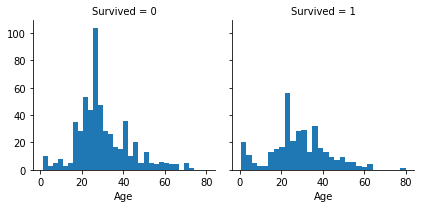

In [29]:
#it seeems like family size does not plat that much rule on determining
#the survival rate so we will ignore that but for that we will keep it

# now visualizing the numerical feature which are age and Fare
g = sns.FacetGrid(training_raw, col = 'Survived')
g.map(plt.hist, 'Age', bins = 30)

#it seems that with little age and those with age high had high survival rate

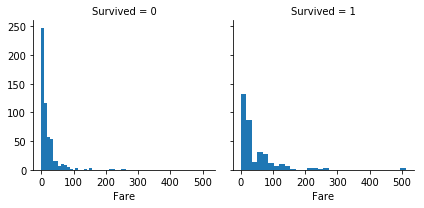

In [30]:
# Similarly for fare
g = sns.FacetGrid(training_raw, col = 'Survived')
g.map(plt.hist, 'Fare', bins = 30)
# it seems that those with high fare had high survival chance

In [31]:
training_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize,Alone,Child
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,7.2500,S,2,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,71.2833,C,2,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,7.9250,S,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,53.1000,S,2,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,8.0500,S,1,1,0


In [32]:
# now handling name and Embarked variable
for dataset in combine:
    dataset['Title'] = dataset['Name'].str.split(',', expand = True)[1].str.split('.', expand = True)[0]

In [33]:
title_count = training_raw['Title'].value_counts() < 10
training_raw['Title'] = training_raw['Title'].apply(lambda x: 'Misc' if title_count.loc[x] == True else str(x))
training_raw['Title'].value_counts()

 Mr        517
 Miss      182
 Mrs       125
 Master     40
Misc        27
Name: Title, dtype: int64

In [34]:
#SImilarly for testing data
title_count = testing_raw['Title'].value_counts() < 10
testing_raw['Title'] = testing_raw['Title'].apply(lambda x: 'Misc' if title_count.loc[x] == True else str(x))
testing_raw['Title'].value_counts()

 Mr        240
 Miss       78
 Mrs        72
 Master     21
Misc         7
Name: Title, dtype: int64

In [35]:
# dropping the name variable 
passengerId = testing_raw['PassengerId']
for dataset in combine:
    dataset.drop(['Name', 'PassengerId'], axis = 1, inplace = True)

In [36]:
#handling categorical
training_one_hot_encoded = pd.get_dummies(training_raw)
testing_one_hot_encoded = pd.get_dummies(testing_raw)
training_target = training_one_hot_encoded['Survived']
training_one_hot_encoded.drop(['Survived'], axis = 1, inplace = True)
training_predictors, testing_predictors = training_one_hot_encoded.align(testing_one_hot_encoded, 
                                                                        join = 'left',
                                                                        axis = 1)


In [37]:
training_predictors.head()

,Pclass,Sex,Age,Fare,FamilySize,Alone,Child,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,3,0,22.0,7.2500,2,0,0,0,0,1,0,0,1,0,0
1,1,1,38.0,71.2833,2,0,0,1,0,0,0,0,0,1,0
2,3,1,26.0,7.9250,1,1,0,0,0,1,0,1,0,0,0
3,1,1,35.0,53.1000,2,0,0,0,0,1,0,0,0,1,0
4,3,0,35.0,8.0500,1,1,0,0,0,1,0,0,1,0,0


In [38]:
X = training_predictors.astype('float')
estimators = [('std', StandardScaler()), ('Forest',RandomForestClassifier(n_estimators=100, max_depth=10, max_leaf_nodes=11,
                                                                         random_state = 0))]
pipeline = Pipeline(estimators)
results = cross_val_score(pipeline, X, training_target, cv = 10)
results.mean()

0.8327803314039268

In [39]:
Age_mean = training_predictors['Age'].mean()
Age_std = training_predictors['Age'].std()
Fare_mean = training_predictors['Fare'].mean()
Fare_std = training_predictors['Fare'].std()
combine = [training_predictors, testing_predictors]
for dataset in combine:
    dataset['Age'] = (dataset['Age']- Age_mean)/Age_std
    dataset['Fare'] = (dataset['Fare'] - Fare_mean)/ Fare_std


In [40]:
training_predictors.head()

,Pclass,Sex,Age,Fare,FamilySize,Alone,Child,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,3,0,-0.548625,-0.502163,2,0,0,0,0,1,0,0,1,0,0
1,1,1,0.654975,0.786404,2,0,0,1,0,0,0,0,0,1,0
2,3,1,-0.247725,-0.488580,1,1,0,0,0,1,0,1,0,0,0
3,1,1,0.429300,0.420494,2,0,0,0,0,1,0,0,0,1,0
4,3,0,0.429300,-0.486064,1,1,0,0,0,1,0,0,1,0,0


In [41]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, max_leaf_nodes=11,
                                                                         random_state = 0)
model.fit(training_predictors, training_target)
answers = model.predict(testing_predictors)

In [42]:
final_file = pd.DataFrame({'PassengerId':passengerId, 'Survived':answers})
final_file.to_csv('RandomResult.csv', index = False)

In [43]:
#Using XGB Classifier
train_X, test_X, train_y, test_y = train_test_split(training_predictors, training_target, test_size = 0.30, random_state = 0,
                                                    stratify =training_target )
my_model = XGBClassifier(n_estimators=1000, learning_rate=0.04, random_state = 0, max_depth=10)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=True)

[0]	validation_0-error:0.201493
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.19403
[2]	validation_0-error:0.186567
[3]	validation_0-error:0.186567
[4]	validation_0-error:0.186567
[5]	validation_0-error:0.171642
[6]	validation_0-error:0.171642
[7]	validation_0-error:0.16791
[8]	validation_0-error:0.164179
[9]	validation_0-error:0.164179
[10]	validation_0-error:0.156716
[11]	validation_0-error:0.156716
[12]	validation_0-error:0.156716
[13]	validation_0-error:0.156716
[14]	validation_0-error:0.156716
[15]	validation_0-error:0.145522
[16]	validation_0-error:0.145522
[17]	validation_0-error:0.149254
[18]	validation_0-error:0.145522
[19]	validation_0-error:0.149254
[20]	validation_0-error:0.152985
Stopping. Best iteration:
[15]	validation_0-error:0.145522



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.04, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [44]:
my_model = XGBClassifier(n_estimators=15, learning_rate=0.04, random_state = 0, max_depth=10)
my_model.fit(training_predictors, training_target)
answers = my_model.predict(testing_predictors)
final_file = pd.DataFrame({'PassengerId':passengerId, 'Survived':answers})
final_file.to_csv('XGBResult.csv', index = False)

In [45]:
training_predictors.shape[1]

15

In [46]:
# baseline model
def create_baseline():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],))) #input shape need to be vector so here its (60, )
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model

In [111]:
seed = 7
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.82% (3.80%)


In [110]:
# smaller model
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(15,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.38% (3.87%)


In [112]:
# smaller model
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(15,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 81.93% (3.95%)


In [113]:
# smaller model
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(20,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.26% (3.70%)


In [114]:
# smaller model
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(70,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.71% (4.00%)


In [116]:
# smaller model
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(35,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.49% (4.07%)


In [117]:
# smaller model
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 83.05% (3.08%)


In [118]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = sgd,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.27% (2.76%)


In [119]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = sgd,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.49% (2.83%)


In [120]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = sgd,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 74.77% (7.06%)


In [121]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.5)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = sgd,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 81.48% (2.89%)


In [122]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = sgd,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 81.82% (3.18%)


In [123]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.009, decay=1e-6, momentum=0.9)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = sgd,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.16% (3.33%)


In [124]:
from keras import optimizers
Rms = optimizers.RMSprop(lr=0.05)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = Rms,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 78.91% (6.15%)


In [125]:

Rms = optimizers.RMSprop(lr=0.009)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = Rms,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 81.04% (3.55%)


In [126]:
# smaller model
Adam = optimizers.Adam(lr=0.0009)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = Adam,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.94% (2.87%)


In [127]:
# smaller model
Adam = optimizers.Adam(lr=0.002)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = Adam,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.94% (2.65%)


In [128]:
# smaller model
Adam = optimizers.Adam(lr=0.003)
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = Adam,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.72% (2.24%)


In [129]:
# smaller model
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10, activation = 'relu'))
  model.add(layers.Dense(3, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 81.71% (2.78%)


In [52]:
# smaller model
seed = 7
np.random.seed(seed)
def create_smaller_1():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal', input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10,kernel_initializer = 'normal', activation = 'relu'))
  model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller_1, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 83.16% (3.35%)


In [59]:
# smaller model
seed = 7
np.random.seed(seed)
def create_smaller_2():
  sgd = SGD(lr=0.09, momentum=0.9, decay=0.0, nesterov=False)
  model = models.Sequential()
  
  model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal',kernel_constraint = maxnorm(3), 
                         input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dense(10,kernel_initializer = 'normal',kernel_constraint = maxnorm(3), activation = 'relu'))
  model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
  model.compile(optimizer = sgd,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller_2, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 61.50% (8.80%)


In [60]:
# smaller model
seed = 7
np.random.seed(seed)
def create_smaller_2():
  sgd = SGD(lr=0.09, momentum=0.9, decay=0.0, nesterov=False)
  model = models.Sequential()
  
  model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal',kernel_constraint = maxnorm(3), 
                         input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(10,kernel_initializer = 'normal',kernel_constraint = maxnorm(3), activation = 'relu'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
  model.compile(optimizer = sgd,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller_2, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 61.62% (0.28%)


In [62]:
# smaller model
seed = 7
np.random.seed(seed)
def create_smaller_2():
  model = models.Sequential()
  adam = optimizers.Adam(lr = 0.002)
  model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal',kernel_constraint = maxnorm(3), 
                         input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(10,kernel_initializer = 'normal',kernel_constraint = maxnorm(3), activation = 'relu'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
  model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller_2, epochs=9, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 82.15% (3.50%)


In [63]:
# smaller model
seed = 7
np.random.seed(seed)
def create_smaller_2():
  model = models.Sequential()
  adam = optimizers.Adam(lr = 0.002)
  model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal',kernel_constraint = maxnorm(3), 
                         input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dropout(0.40))
  model.add(layers.Dense(10,kernel_initializer = 'normal',kernel_constraint = maxnorm(3), activation = 'relu'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
  model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller_2, epochs=20, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/20
801/801 [==============================] - 3s 4ms/step - loss: 0.5999 - acc: 0.6879
Epoch 2/20
801/801 [==============================] - 0s 395us/step - loss: 0.4677 - acc: 0.8027
Epoch 3/20
801/801 [==============================] - ETA: 0s - loss: 0.4823 - acc: 0.812 - 0s 429us/step - loss: 0.4690 - acc: 0.8202
Epoch 4/20
801/801 [==============================] - ETA: 0s - loss: 0.4476 - acc: 0.812 - 0s 504us/step - loss: 0.4451 - acc: 0.8177
Epoch 5/20
801/801 [==============================] - 0s 420us/step - loss: 0.4279 - acc: 0.8290
Epoch 6/20
801/801 [==============================] - 0s 409us/step - loss: 0.4375 - acc: 0.8165
Epoch 7/20
801/801 [==============================] - 0s 415us/step - loss: 0.4207 - acc: 0.8165
Epoch 8/20
801/801 [==============================] - 0s 489us/step - loss: 0.4304 - acc: 0.8252
Epoch 9/20
801/801 [==============================] - 0s 419us/step - loss: 0.4286 - acc: 0.8177
Epoch 10/20
801/801 [==============================] 

802/802 [==============================] - 3s 4ms/step - loss: 0.5951 - acc: 0.6758
Epoch 2/20
802/802 [==============================] - 0s 469us/step - loss: 0.4868 - acc: 0.7993
Epoch 3/20
802/802 [==============================] - 0s 479us/step - loss: 0.4610 - acc: 0.8267
Epoch 4/20
802/802 [==============================] - 0s 474us/step - loss: 0.4499 - acc: 0.8267
Epoch 5/20
802/802 [==============================] - 0s 479us/step - loss: 0.4340 - acc: 0.8392
Epoch 6/20
802/802 [==============================] - 0s 474us/step - loss: 0.4431 - acc: 0.8392
Epoch 7/20
802/802 [==============================] - 0s 484us/step - loss: 0.4317 - acc: 0.8229
Epoch 8/20
802/802 [==============================] - 0s 489us/step - loss: 0.4257 - acc: 0.8292
Epoch 9/20
802/802 [==============================] - 0s 479us/step - loss: 0.4198 - acc: 0.8392
Epoch 10/20
802/802 [==============================] - 0s 489us/step - loss: 0.4219 - acc: 0.8342
Epoch 11/20
802/802 [=====================

Epoch 3/20
802/802 [==============================] - 0s 593us/step - loss: 0.4595 - acc: 0.8167
Epoch 4/20
802/802 [==============================] - 1s 663us/step - loss: 0.4450 - acc: 0.8217
Epoch 5/20
802/802 [==============================] - 1s 838us/step - loss: 0.4516 - acc: 0.8229
Epoch 6/20
802/802 [==============================] - 0s 618us/step - loss: 0.4453 - acc: 0.8292
Epoch 7/20
802/802 [==============================] - 1s 728us/step - loss: 0.4313 - acc: 0.8279
Epoch 8/20
802/802 [==============================] - 1s 638us/step - loss: 0.4461 - acc: 0.8292
Epoch 9/20
802/802 [==============================] - 0s 593us/step - loss: 0.4194 - acc: 0.8279
Epoch 10/20
802/802 [==============================] - 0s 494us/step - loss: 0.4273 - acc: 0.8292
Epoch 11/20
802/802 [==============================] - 0s 549us/step - loss: 0.4234 - acc: 0.8229
Epoch 12/20
802/802 [==============================] - 0s 584us/step - loss: 0.4268 - acc: 0.8242
Epoch 13/20
802/802 [======

In [70]:
# smaller model
seed = 7
np.random.seed(seed)
def create_smaller_2():
  model = models.Sequential()
  adam = optimizers.Adam(lr = 0.003)
  model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal',kernel_constraint = maxnorm(3), 
                         input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(10,kernel_initializer = 'normal',kernel_constraint = maxnorm(3), activation = 'relu'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
  model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller_2, epochs=20, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/20
801/801 [==============================] - 6s 7ms/step - loss: 0.5824 - acc: 0.7004
Epoch 2/20
801/801 [==============================] - 1s 949us/step - loss: 0.4706 - acc: 0.7965
Epoch 3/20
801/801 [==============================] - 1s 799us/step - loss: 0.4779 - acc: 0.8040
Epoch 4/20
801/801 [==============================] - 1s 864us/step - loss: 0.4540 - acc: 0.8090
Epoch 5/20
801/801 [==============================] - 1s 849us/step - loss: 0.4284 - acc: 0.8265
Epoch 6/20
801/801 [==============================] - 1s 759us/step - loss: 0.4377 - acc: 0.8152
Epoch 7/20
801/801 [==============================] - 1s 794us/step - loss: 0.4273 - acc: 0.8190
Epoch 8/20
801/801 [==============================] - 1s 769us/step - loss: 0.4394 - acc: 0.8152
Epoch 9/20
801/801 [==============================] - 1s 749us/step - loss: 0.4367 - acc: 0.8215
Epoch 10/20
801/801 [==============================] - 1s 779us/step - loss: 0.4283 - acc: 0.8290
Epoch 11/20
801/801 [==========

802/802 [==============================] - 1s 768us/step - loss: 0.4894 - acc: 0.8080
Epoch 3/20
802/802 [==============================] - 1s 653us/step - loss: 0.4654 - acc: 0.8217
Epoch 4/20
802/802 [==============================] - 1s 748us/step - loss: 0.4447 - acc: 0.8217
Epoch 5/20
802/802 [==============================] - 0s 604us/step - loss: 0.4362 - acc: 0.8217
Epoch 6/20
802/802 [==============================] - 0s 608us/step - loss: 0.4399 - acc: 0.8379
Epoch 7/20
802/802 [==============================] - 0s 609us/step - loss: 0.4254 - acc: 0.8267
Epoch 8/20
802/802 [==============================] - 1s 798us/step - loss: 0.4278 - acc: 0.8292
Epoch 9/20
802/802 [==============================] - 1s 688us/step - loss: 0.4228 - acc: 0.8354
Epoch 10/20
802/802 [==============================] - 1s 833us/step - loss: 0.4219 - acc: 0.8229
Epoch 11/20
802/802 [==============================] - 1s 878us/step - loss: 0.4112 - acc: 0.8342
Epoch 12/20
802/802 [==================

802/802 [==============================] - 0s 605us/step - loss: 0.4446 - acc: 0.8279
Epoch 5/20
802/802 [==============================] - 1s 730us/step - loss: 0.4643 - acc: 0.8180
Epoch 6/20
802/802 [==============================] - 1s 720us/step - loss: 0.4557 - acc: 0.8292
Epoch 7/20
802/802 [==============================] - 0s 607us/step - loss: 0.4355 - acc: 0.8180
Epoch 8/20
802/802 [==============================] - 0s 594us/step - loss: 0.4506 - acc: 0.8204
Epoch 9/20
802/802 [==============================] - 0s 590us/step - loss: 0.4219 - acc: 0.8317
Epoch 10/20
802/802 [==============================] - 0s 622us/step - loss: 0.4382 - acc: 0.8192
Epoch 11/20
802/802 [==============================] - 0s 591us/step - loss: 0.4320 - acc: 0.8279
Epoch 12/20
802/802 [==============================] - 0s 623us/step - loss: 0.4332 - acc: 0.8354
Epoch 13/20
802/802 [==============================] - 0s 591us/step - loss: 0.4181 - acc: 0.8292
Epoch 14/20
802/802 [================

In [67]:
# smaller model
seed = 7
np.random.seed(seed)
def create_smaller_2():
  model = models.Sequential()
  adam = optimizers.Adam(lr = 0.005)
  model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal',kernel_constraint = maxnorm(3), 
                         input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dropout(0.35))
  model.add(layers.Dense(10,kernel_initializer = 'normal',kernel_constraint = maxnorm(3), activation = 'relu'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
  model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller_2, epochs=20, batch_size=10, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/20
801/801 [==============================] - 4s 5ms/step - loss: 0.5809 - acc: 0.7029
Epoch 2/20
801/801 [==============================] - ETA: 0s - loss: 0.4790 - acc: 0.786 - 0s 300us/step - loss: 0.4774 - acc: 0.7878
Epoch 3/20
801/801 [==============================] - 0s 290us/step - loss: 0.4615 - acc: 0.8127
Epoch 4/20
801/801 [==============================] - 0s 275us/step - loss: 0.4657 - acc: 0.8065 0s - loss: 0.3828 - acc: 0.
Epoch 5/20
801/801 [==============================] - 0s 285us/step - loss: 0.4551 - acc: 0.8190
Epoch 6/20
801/801 [==============================] - 0s 285us/step - loss: 0.4410 - acc: 0.8240
Epoch 7/20
801/801 [==============================] - 0s 295us/step - loss: 0.4203 - acc: 0.8290
Epoch 8/20
801/801 [==============================] - 0s 295us/step - loss: 0.4347 - acc: 0.8215
Epoch 9/20
801/801 [==============================] - 0s 335us/step - loss: 0.4345 - acc: 0.8152
Epoch 10/20
801/801 [==============================] - 0s 330us

802/802 [==============================] - 0s 239us/step - loss: 0.4756 - acc: 0.8130
Epoch 3/20
802/802 [==============================] - 0s 259us/step - loss: 0.4568 - acc: 0.8229
Epoch 4/20
802/802 [==============================] - 0s 264us/step - loss: 0.4575 - acc: 0.8267
Epoch 5/20
802/802 [==============================] - 0s 254us/step - loss: 0.4372 - acc: 0.8317
Epoch 6/20
802/802 [==============================] - 0s 249us/step - loss: 0.4146 - acc: 0.8392
Epoch 7/20
802/802 [==============================] - 0s 279us/step - loss: 0.4270 - acc: 0.8329
Epoch 8/20
802/802 [==============================] - 0s 249us/step - loss: 0.4200 - acc: 0.8354
Epoch 9/20
802/802 [==============================] - 0s 274us/step - loss: 0.4166 - acc: 0.8317
Epoch 10/20
802/802 [==============================] - 0s 254us/step - loss: 0.4164 - acc: 0.8329
Epoch 11/20
802/802 [==============================] - 0s 249us/step - loss: 0.4076 - acc: 0.8429
Epoch 12/20
802/802 [==================

Epoch 4/20
802/802 [==============================] - 0s 439us/step - loss: 0.4583 - acc: 0.8167
Epoch 5/20
802/802 [==============================] - 0s 369us/step - loss: 0.4424 - acc: 0.8254
Epoch 6/20
802/802 [==============================] - 0s 339us/step - loss: 0.4487 - acc: 0.8204
Epoch 7/20
802/802 [==============================] - 0s 339us/step - loss: 0.4268 - acc: 0.8242
Epoch 8/20
802/802 [==============================] - 0s 334us/step - loss: 0.4359 - acc: 0.8267
Epoch 9/20
802/802 [==============================] - 0s 324us/step - loss: 0.4341 - acc: 0.8367
Epoch 10/20
802/802 [==============================] - 0s 374us/step - loss: 0.4255 - acc: 0.8317
Epoch 11/20
802/802 [==============================] - 0s 389us/step - loss: 0.4319 - acc: 0.8229
Epoch 12/20
802/802 [==============================] - 0s 409us/step - loss: 0.4285 - acc: 0.8292
Epoch 13/20
802/802 [==============================] - 0s 434us/step - loss: 0.4350 - acc: 0.8242
Epoch 14/20
802/802 [=====

In [68]:
# smaller model
seed = 7
np.random.seed(seed)
def create_smaller_2():
  model = models.Sequential()
  adam = optimizers.Adam(lr = 0.005)
  model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal',kernel_constraint = maxnorm(3), 
                         input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dropout(0.35))
  model.add(layers.Dense(10,kernel_initializer = 'normal',kernel_constraint = maxnorm(3), activation = 'relu'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
  model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller_2, epochs=15, batch_size=10, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/15
801/801 [==============================] - 4s 5ms/step - loss: 0.5805 - acc: 0.7029
Epoch 2/15
801/801 [==============================] - 0s 315us/step - loss: 0.4778 - acc: 0.7903
Epoch 3/15
801/801 [==============================] - 0s 310us/step - loss: 0.4597 - acc: 0.8115
Epoch 4/15
801/801 [==============================] - 0s 315us/step - loss: 0.4638 - acc: 0.8040
Epoch 5/15
801/801 [==============================] - 0s 305us/step - loss: 0.4564 - acc: 0.8177
Epoch 6/15
801/801 [==============================] - 0s 315us/step - loss: 0.4394 - acc: 0.8277
Epoch 7/15
801/801 [==============================] - 0s 310us/step - loss: 0.4184 - acc: 0.8327
Epoch 8/15
801/801 [==============================] - 0s 360us/step - loss: 0.4353 - acc: 0.8215
Epoch 9/15
801/801 [==============================] - 0s 390us/step - loss: 0.4376 - acc: 0.8140 0s - loss: 0.4349 - acc: 0.8
Epoch 10/15
801/801 [==============================] - 0s 305us/step - loss: 0.4095 - acc: 0.8265
Ep

802/802 [==============================] - 0s 284us/step - loss: 0.4448 - acc: 0.8155
Epoch 8/15
802/802 [==============================] - 0s 289us/step - loss: 0.4295 - acc: 0.8279
Epoch 9/15
802/802 [==============================] - 0s 289us/step - loss: 0.4273 - acc: 0.8167
Epoch 10/15
802/802 [==============================] - 0s 294us/step - loss: 0.4159 - acc: 0.8329
Epoch 11/15
802/802 [==============================] - 0s 324us/step - loss: 0.4050 - acc: 0.8204
Epoch 12/15
802/802 [==============================] - 0s 294us/step - loss: 0.4312 - acc: 0.8292
Epoch 13/15
802/802 [==============================] - 0s 294us/step - loss: 0.4210 - acc: 0.8242
Epoch 14/15
802/802 [==============================] - 0s 274us/step - loss: 0.4256 - acc: 0.8354
Epoch 15/15
89/89 [==============================] - 2s 25ms/step
Epoch 1/15
802/802 [==============================] - 5s 6ms/step - loss: 0.5917 - acc: 0.6870
Epoch 2/15
802/802 [==============================] - 0s 399us/step -

In [72]:
# smaller model
seed = 7
np.random.seed(seed)
def create_smaller_2():
  model = models.Sequential()
  adam = optimizers.Adam(lr = 0.003)
  model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal',kernel_constraint = maxnorm(3), 
                         input_shape =(training_predictors.shape[1],)))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(10,kernel_initializer = 'normal',kernel_constraint = maxnorm(3), activation = 'relu'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
  model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimator = KerasClassifier(build_fn=create_smaller_2, epochs=20, batch_size=128, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, training_predictors, training_target, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/20
801/801 [==============================] - 6s 7ms/step - loss: 0.6895 - acc: 0.6280
Epoch 2/20
801/801 [==============================] - 0s 60us/step - loss: 0.6772 - acc: 0.6192
Epoch 3/20
801/801 [==============================] - 0s 65us/step - loss: 0.6519 - acc: 0.6392
Epoch 4/20
801/801 [==============================] - 0s 65us/step - loss: 0.6138 - acc: 0.6654
Epoch 5/20
801/801 [==============================] - 0s 65us/step - loss: 0.5727 - acc: 0.7141
Epoch 6/20
801/801 [==============================] - 0s 70us/step - loss: 0.5212 - acc: 0.7765
Epoch 7/20
801/801 [==============================] - 0s 70us/step - loss: 0.4908 - acc: 0.7853
Epoch 8/20
801/801 [==============================] - 0s 65us/step - loss: 0.5011 - acc: 0.7978
Epoch 9/20
801/801 [==============================] - 0s 60us/step - loss: 0.4707 - acc: 0.8015
Epoch 10/20
801/801 [==============================] - 0s 60us/step - loss: 0.4762 - acc: 0.7853
Epoch 11/20
801/801 [===================

802/802 [==============================] - 0s 65us/step - loss: 0.6460 - acc: 0.6172
Epoch 4/20
802/802 [==============================] - 0s 70us/step - loss: 0.6036 - acc: 0.6309
Epoch 5/20
802/802 [==============================] - 0s 75us/step - loss: 0.5669 - acc: 0.6958
Epoch 6/20
802/802 [==============================] - 0s 65us/step - loss: 0.5394 - acc: 0.7282
Epoch 7/20
802/802 [==============================] - 0s 60us/step - loss: 0.5136 - acc: 0.7843
Epoch 8/20
802/802 [==============================] - 0s 60us/step - loss: 0.5020 - acc: 0.7880
Epoch 9/20
802/802 [==============================] - 0s 60us/step - loss: 0.4819 - acc: 0.8055
Epoch 10/20
802/802 [==============================] - 0s 65us/step - loss: 0.4698 - acc: 0.8092
Epoch 11/20
802/802 [==============================] - 0s 60us/step - loss: 0.4706 - acc: 0.8092
Epoch 12/20
802/802 [==============================] - 0s 65us/step - loss: 0.4447 - acc: 0.8279
Epoch 13/20
802/802 [===========================

802/802 [==============================] - 0s 60us/step - loss: 0.5799 - acc: 0.6808
Epoch 6/20
802/802 [==============================] - 0s 65us/step - loss: 0.5427 - acc: 0.7319
Epoch 7/20
802/802 [==============================] - 0s 55us/step - loss: 0.5066 - acc: 0.7855
Epoch 8/20
802/802 [==============================] - 0s 63us/step - loss: 0.4957 - acc: 0.7756
Epoch 9/20
802/802 [==============================] - 0s 60us/step - loss: 0.4885 - acc: 0.7930
Epoch 10/20
802/802 [==============================] - 0s 60us/step - loss: 0.4833 - acc: 0.8092
Epoch 11/20
802/802 [==============================] - 0s 65us/step - loss: 0.4622 - acc: 0.8030
Epoch 12/20
802/802 [==============================] - 0s 65us/step - loss: 0.4653 - acc: 0.8130
Epoch 13/20
802/802 [==============================] - 0s 55us/step - loss: 0.4502 - acc: 0.8142
Epoch 14/20
802/802 [==============================] - 0s 65us/step - loss: 0.4587 - acc: 0.8192
Epoch 15/20
802/802 [=========================

In [77]:
#USing 83.39% accuracy model
np.random.seed(seed)
model = models.Sequential()
adam = optimizers.Adam(lr = 0.003)
model.add(layers.Dense(60,activation = 'relu',kernel_initializer = 'normal',kernel_constraint = maxnorm(3), 
                         input_shape =(training_predictors.shape[1],)))
model.add(layers.Dropout(0.50))
model.add(layers.Dense(10,kernel_initializer = 'normal',kernel_constraint = maxnorm(3), activation = 'relu'))
model.add(layers.Dropout(0.20))
model.add(layers.Dense(1,kernel_initializer = 'normal', activation = 'sigmoid'))
model.compile(optimizer = adam,loss = 'binary_crossentropy',metrics=['binary_accuracy'] )
model.fit(training_predictors,
          training_target,
                    
                    epochs=20,
                    batch_size=5,
                    verbose = 0)

In [93]:
answers = model.predict(testing_predictors).round().astype(int)

In [98]:
final_file = pd.DataFrame({'PassengerId':passengerId, 'Survived':answers.ravel()})
final_file.to_csv('deepResult.csv', index = False)